# Scrape Results of all UFC Fights

In [ ]:
from bs4 import BeautifulSoup
import requests
import pickle
import os

# include all paths to data from local storage location
PATH_TO_UFC_FIGHT_RESULTS = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_results.pkl'
PATH_TO_UFC_FIGHT_PRED_DATA = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_data.csv'


In [ ]:
fight_res = {}

url = requests.get("http://ufcstats.com/statistics/events/completed?page=all")
html = url.text

soup = BeautifulSoup(html)

for i, a in enumerate(soup.find_all('a', href=True)):
    
    if i in set(range(60, 636)):
        print("Reading UFC Event:", a['href'])
        ev_url = requests.get(a['href'])
        ev_html = ev_url.text
        ev_soup = BeautifulSoup(ev_html)
        tr = ev_soup.find_all('tr', attrs={'class': 'b-fight-details__table-row b-fight-details__table-row__hover js-fight-details-click'})
        
        for el in tr:
            p = el.find_all("p", attrs={'class': 'b-fight-details__table-text'})
            if p is not None:
                print("Fighter #1:", p[1].get_text().strip())
                print("Fighter #2:", p[2].get_text().strip())
                print("Win by:", p[12].get_text().strip())
                
                f1 = p[1].get_text().strip().lower().replace(' ', '_')
                f2 = p[2].get_text().strip().lower().replace(' ', '_')
                w_method = p[12].get_text().strip()

                fight_res[min(f1, f2) + '_'+ max(f1, f2)] = w_method
            
        

        
# Write out results to file
with open(PATH_TO_UFC_FIGHT_RESULTS, 'wb') as f:
    pickle.dump(fight_res, f)

# Or load in the data

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

# include all paths to data from local storage location
PATH_TO_UFC_FIGHT_RESULTS = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_results.pkl'
PATH_TO_UFC_FIGHT_PRED_DATA = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_data.csv'

# Load in results from file
with open(PATH_TO_UFC_FIGHT_RESULTS, 'rb') as f:
    fight_res = pickle.load(f)

# Fill in the UFC data with missing KO/TKO information

In [2]:
ufc_df = pd.read_csv(PATH_TO_UFC_FIGHT_PRED_DATA)
fighters = ufc_df[['R_fighter', 'B_fighter']]

app_results = []
skipped_count = 0

for i in range(len(fighters)):
    print(fighters.iloc[i, 0], 'vs', fighters.iloc[i, 1])
    f1 = fighters.iloc[i, 0].strip().lower().replace(' ', '_')
    f2 = fighters.iloc[i, 1].strip().lower().replace(' ', '_')
    try:
        result = fight_res[min(f1, f2) + '_'+ max(f1, f2)]
        app_results.append(result)
    except KeyError:
        print('Skipped')
        app_results.append('Unknown')
        skipped_count += 1

ufc_df['results'] = pd.Index(app_results)

# remove NaNs
ufc_df = ufc_df.dropna()

Adrian Yanez vs Gustavo Lopez
Trevin Giles vs Roman Dolidze
Tai Tuivasa vs Harry Hunsucker
Cheyanne Buys vs Montserrat Conejo
Skipped
Marion Reneau vs Macy Chiasson
Leonardo Santos vs Grant Dawson
Song Kenan vs Max Griffin
Derek Brunson vs Kevin Holland
Montel Jackson vs Jesse Strader
Bruno Silva vs JP Buys
Manel Kape vs Matheus Nicolau
Misha Cirkunov vs Ryan Spann
Leon Edwards vs Belal Muhammad
Skipped
Charles Jourdain vs Marcelo Rojo
Eryk Anders vs Darren Stewart
Angela Hill vs Ashley Yoder
Jonathan Martinez vs Davey Grant
Dan Ige vs Gavin Tucker
Nasrat Haqparast vs Rafa Garcia
Cortney Casey vs JJ Aldrich
Matthew Semelsberger vs Jason Witt
Rani Yahya vs Ray Rodriguez
Gloria de Paula vs Jinh Yu Frey
Dominick Cruz vs Casey Kenney
Song Yadong vs Kyler Phillips
Petr Yan vs Aljamain Sterling
Jan Blachowicz vs Israel Adesanya
Thiago Santos vs Aleksandar Rakic
Joseph Benavidez vs Askar Askarov
Amanda Nunes vs Megan Anderson
Islam Makhachev vs Drew Dober
Tim Elliott vs Jordan Espinosa
Livinh

Randa Markos vs Ashley Yoder
Frank Camacho vs Beneil Dariush
Muslim Salikhov vs Laureano Staropoli
Demian Maia vs Ben Askren
Alex White vs Rafael Fiziev
Maurice Greene vs Sergei Pavlovich
Loma Lookboonmee vs Aleksandra Albu
Raphael Pessoa vs Jeff Hughes
Maycee Barber vs Gillian Robertson
Greg Hardy vs Ben Sosoli
Skipped
Deron Winn vs Darren Stewart
Molly McCann vs Diana Belbita
Charles Rosa vs Manny Bermudez
Joe Lauzon vs Jonathan Pearce
Dominick Reyes vs Chris Weidman
Yair Rodriguez vs Jeremy Stephens
Randy Costa vs Boston Salmon
Brendan Allen vs Kevin Holland
Kyle Bochniak vs Sean Woodson
Daniel Spitz vs Tanner Boser
Court McGee vs Sean Brady
Ryan Spann vs Devin Clark
Mackenzie Dern vs Amanda Ribas
Mike Davis vs Thomas Gifford
Cub Swanson vs Kron Gracie
Matt Frevola vs Luis Pena
Eryk Anders vs Gerald Meerschaert
Joanna Jedrzejczyk vs Michelle Waterson
Skipped
Niko Price vs James Vick
Max Griffin vs Alex Morono
Deiveson Figueiredo vs Tim Elliott
Marlon Vera vs Andre Ewell
Miguel Baeza

Nad Narimani vs Anderson Dos Santos
Laureano Staropoli vs Hector Aldana
Maycee Barber vs Hannah Cifers
Beneil Dariush vs Thiago Moises
Michael Trizano vs Luis Pena
Chas Skelly vs Bobby Moffett
Skipped
Raquel Pennington vs Germaine de Randamie
Chan Sung Jung vs Yair Rodriguez
Ashley Yoder vs Amanda Cooper
Donald Cerrone vs Mike Perry
Devonte Smith vs Julian Erosa
Joseph Morales vs Eric Shelton
Davi Ramos vs John Gunther
Mark De La Rosa vs Joby Sanchez
Jason Knight vs Jordan Rinaldi
Karl Roberson vs Jack Marshman
David Branch vs Jared Cannonier
Daniel Cormier vs Derrick Lewis
Derek Brunson vs Israel Adesanya
Julio Arce vs Sheymon Moraes
Sijara Eubanks vs Roxanne Modafferi
Chris Weidman vs Jacare Souza
Matt Frevola vs Lando Vannata
Skipped
Lyman Good vs Ben Saunders
Shane Burgos vs Kurt Holobaugh
Adam Wieczorek vs Marcos Rogerio de Lima
Misha Cirkunov vs Patrick Cummins
Gian Villante vs Ed Herman
Nordine Taleb vs Sean Strickland
Alex Garcia vs Court McGee
Michael Johnson vs Artem Lobov
Vo

Cody Stamann vs Terrion Ware
Jordan Mein vs Belal Muhammad
Trevin Giles vs James Bochnovic
Marc Diakiese vs Drakkar Klose
Jared Cannonier vs Nick Roehrick
Dhiego Lima vs Jesse Taylor
James Krause vs Tom Gallicchio
Michael Johnson vs Justin Gaethje
Jordan Johnson vs Marcel Fortuna
Angela Hill vs Ashley Yoder
Brad Tavares vs Elias Theodorou
Tecia Torres vs Juliana Lima
Gray Maynard vs Teruto Ishihara
Ed Herman vs CB Dollaway
Michael Chiesa vs Kevin Lee
Vitor Miranda vs Marvin Vettori
BJ Penn vs Dennis Siver
Tim Means vs Alex Garcia
Tim Boetsch vs Johny Hendricks
Clay Guida vs Erik Koch
Felice Herrig vs Justine Kish
Joachim Christensen vs Dominick Reyes
Josh Stansbury vs Jeremy Kimball
Devin Powell vs Darrell Horcher
Jared Gordon vs Michel Quinones
Anthony Rocco Martin vs Johnny Case
Carla Esparza vs Maryna Moroz
Alex Caceres vs Rolando Dy
Cyril Asker vs Walt Harris
Takanori Gomi vs Jon Tuck
Justin Scoggins vs Yuta Sasaki
Dong Hyun Kim vs Colby Covington
Tarec Saffiedine vs Rafael Dos Anj

Mike Pyle vs Sean Spencer
Misha Cirkunov vs Alex Nicholson
Joshua Burkman vs KJ Noons
Ovince Saint Preux vs Rafael Cavalcante
Joseph Benavidez vs Zach Makovsky
Roy Nelson vs Jared Rosholt
Noad Lahat vs Diego Rivas
Ray Borg vs Justin Scoggins
Mickey Gall vs Mike Jackson
Artem Lobov vs Alex White
Sage Northcutt vs Bryan Barberena
Tarec Saffiedine vs Jake Ellenberger
Olivier Aubin-Mercier vs Diego Ferreira
Rafael Natal vs Kevin Casey
Dustin Ortiz vs Wilson Reis
Anthony Johnson vs Ryan Bader
Josh Barnett vs Ben Rothwell
Iuri Alcantara vs Jimmie Rivera
Matt Dwyer vs Randy Brown
George Sullivan vs Alexander Yakovlev
Alex Caceres vs Masio Fullen
Damon Jackson vs Levan Makashvili
Skipped
Anthony Rocco Martin vs Felipe Olivieri
Maximo Blanco vs Luke Sanders
Tim Boetsch vs Ed Herman
Patrick Cote vs Ben Saunders
Ross Pearson vs Francisco Trinaldo
Travis Browne vs Matt Mitrione
Anthony Pettis vs Eddie Alvarez
Chris Wade vs Mehdi Baghdad
TJ Dillashaw vs Dominick Cruz
Ilir Latifi vs Sean O'Connell
P

Yoshihiro Akiyama vs Amir Sadollah
Alex Caceres vs Masanori Kanehara
Myles Jury vs Takanori Gomi
Kyoji Horiguchi vs Jon Delos Reyes
Michinori Tanaka vs Kyung Ho Kang
Hyun Gyu Lim vs Takenori Sato
Kazuki Tokudome vs Johnny Case
Maximo Blanco vs Dan Hooker
Antonio Silva vs Andrei Arlovski
Iuri Alcantara vs Russell Doane
Santiago Ponzinibbio vs Wendell Oliveira Marques
Jessica Andrade vs Larissa Pacheco
Gleison Tibau vs Piotr Hallmann
Leonardo Santos vs Efrain Escudero
Igor Araujo vs George Sullivan
Godofredo Pepey vs Dashon Johnson
Paulo Thiago vs Sean Spencer
Francisco Trinaldo vs Leandro Silva
Rani Yahya vs Johnny Bedford
Chris Beal vs Tateki Matsuda
Joe Lauzon vs Michael Chiesa
Jacare Souza vs Gegard Mousasi
Rafael Natal vs Chris Camozzi
Matt Mitrione vs Derrick Lewis
John Moraga vs Justin Scoggins
Al Iaquinta vs Rodrigo Damm
Alistair Overeem vs Ben Rothwell
Sean Soriano vs Chas Skelly
Chris Wade vs Cain Carrizosa
Lorenz Larkin vs Derek Brunson
Bethe Correia vs Shayna Baszler
Ruan Pot

Brad Pickett vs Mike Easton
Akira Corassani vs Robert Peralta
Chris Spang vs Adlan Amagov
Marcus Brimage vs Conor McGregor
Ben Alloway vs Ryan LaFlare
Michael Kuiper vs Tom Lawlor
Papy Abedi vs Besam Yousef
Jake Ellenberger vs Nate Marquardt
Antonio Carvalho vs Darren Elkins
Mike Ricci vs Colin Fletcher
Patrick Cote vs Bobby Voelker
Carlos Condit vs Johny Hendricks
Dan Miller vs Jordan Mein
Georges St-Pierre vs Nick Diaz
Nick Ring vs Chris Camozzi
TJ Dillashaw vs Issei Tamura
Rick Story vs Quinn Mulhern
John Makdessi vs Daron Cruickshank
George Roop vs Reuben Duran
Takeya Mizugaki vs Bryan Caraway
Yushin Okami vs Hector Lombard
Riki Fukuda vs Brad Tavares
Takanori Gomi vs Diego Sanchez
Dong Hyun Kim vs Siyar Bahadurzada
Wanderlei Silva vs Brian Stann
Mizuto Hirota vs Rani Yahya
Stefan Struve vs Mark Hunt
Cristiano Marcello vs Kazuki Tokudome
Alex Caceres vs Kyung Ho Kang
Skipped
Marcelo Guimaraes vs Hyun Gyu Lim
Ronda Rousey vs Liz Carmouche
Urijah Faber vs Ivan Menjivar
Lyoto Machida 

Jim Miller vs Kamal Shalorus
Edson Barboza vs Anthony Njokuani
Mauricio Rua vs Jon Jones
Mirko Filipovic vs Brendan Schaub
Ricardo Almeida vs Mike Pyle
Joseph Benavidez vs Ian Loveland
Kurt Pellegrino vs Gleison Tibau
Erik Koch vs Raphael Assuncao
Constantinos Philippou vs Nick Catone
Alessio Sakara vs Chris Weidman
Joe Stevenson vs Danny Castillo
Brian Bowles vs Damacio Page
Steve Cantwell vs Cyrille Diabate
Diego Sanchez vs Martin Kampmann
Thiago Tavares vs Shane Roller
Takeya Mizugaki vs Reuben Duran
CB Dollaway vs Mark Munoz
Rob Kimmons vs Dongi Yang
Igor Pokrajac vs Todd Brown
David Branch vs Rousimar Palhares
Chris Camozzi vs Kyle Noke
Brian Ebersole vs Chris Lytle
Nick Ring vs Riki Fukuda
George Sotiropoulos vs Dennis Siver
Alexander Gustafsson vs James Te Huna
BJ Penn vs Jon Fitch
Skipped
Michael Bisping vs Jorge Rivera
Ross Pearson vs Spencer Fisher
Zhang Tiequan vs Jason Reinhardt
Tom Blackledge vs Anthony Perosh
Maciej Jewtuszko vs Curt Warburton
Mark Hunt vs Chris Tuchscher

Wanderlei Silva vs Keith Jardine
Rousimar Palhares vs Ivan Salaverry
Rameau Thierry Sokoudjou vs Kazuhiro Nakamura
BJ Penn vs Sean Sherk
Lyoto Machida vs Tito Ortiz
Goran Reljic vs Wilson Gouveia
Thiago Silva vs Antonio Mendes
Yoshiyuki Yoshida vs War Machine
Dong Hyun Kim vs Jason Tan
Shane Carwin vs Christian Wellisch
Jason Day vs Alan Belcher
Georges St-Pierre vs Matt Serra
Mac Danzig vs Mark Bocek
Michael Bisping vs Charles McCarthy
Rich Franklin vs Travis Lutter
Demian Maia vs Ed Herman
Jason MacDonald vs Joe Doerksen
Nate Quarry vs Kalib Starnes
Cain Velasquez vs Brad Morris
Rich Clementi vs Sam Stout
Jonathan Goulet vs Kuniyoshi Hironaka
Matt Hamill vs Tim Boetsch
Marcus Aurelio vs Ryan Roberts
James Irvin vs Houston Alexander
Thiago Alves vs Karo Parisyan
Kenny Florian vs Joe Lauzon
Gray Maynard vs Frankie Edgar
Nate Diaz vs Kurt Pellegrino
Josh Neer vs Din Thomas
Clay Guida vs Samy Schiavo
Manvel Gamburyan vs Jeff Cox
Anthony Johnson vs Tommy Speer
George Sotiropoulos vs Roman

Andrei Arlovski vs Aaron Brink
Jeremy Horn vs Eugene Jackson
Yuki Kondo vs Alexandre Dantas
Maurice Smith vs Bobby Hoffman
Pedro Rizzo vs Dan Severn
Jeff Monson vs Tim Lajcik
Brad Gumm vs CJ Fernandes
Skipped
Fabiano Iha vs Laverne Clark
Ian Freeman vs Tedd Williams
Matt Hughes vs Marcelo Aguiar
Shonie Carter vs Adrian Serrano
Pat Miletich vs John Alessio
Ian Freeman vs Nate Schroeder
Tyrone Roberts vs David Dodd
Amaury Bitetti vs Alex Andrade
Kevin Randleman vs Pedro Rizzo
Jens Pulver vs Joao Roque
Murilo Bustamante vs Yoji Anjo
Laverne Clark vs Koji Oishi
Sanae Kikuta vs Eugene Jackson
Tito Ortiz vs Wanderlei Silva
Ron Waterman vs Satoshi Honma
Ikuhisa Minowa vs Joe Slick
Shonie Carter vs Brad Gumm
Dave Menne vs Fabiano Iha
Scott Adams vs Ian Freeman
Jens Pulver vs David Velasquez
Tedd Williams vs Steve Judson
Bob Cook vs Tiki Ghosn
Lance Gibson vs Jermaine Andre
Pedro Rizzo vs Tsuyoshi Kohsaka
Kevin Randleman vs Pete Williams
Kenichi Yamamoto vs Daiju Takase
Kenichi Yamamoto vs Kats

In [3]:
ufc_data = ufc_df.loc[:, 'title_bout':'R_age']
del ufc_data['B_Weight_lbs'], ufc_data['R_Weight_lbs']

X = pd.get_dummies(ufc_data).to_numpy()
Y = pd.get_dummies(ufc_df['results'] == 'KO/TKO').to_numpy()

print('X Shape:', X.shape, '| Y Shape:', Y.shape)
print('Percentage of postives:', 100 * sum(Y[:, 1]) / Y.shape[0], '%')

X Shape: (3890, 154) | Y Shape: (3890, 2)
Percentage of postives: 32.2879177377892 %


# Multilayer Neural Net Model with Regularization

Using the Multilayer Neural Net Alone resulted in a poor test error. I will attempt to use weight decay regulariazation to provide a way to not use all weights in the neural net construction. We start with large number of Nodes per layer (like 100) since regularization will 'shrink' those that are unnecessary.

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.layers import Dense
from keras.models import Sequential
from keras.backend import clear_session # for memory management 
from sklearn.metrics import confusion_matrix
from keras import regularizers # to provide weight decay

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21, stratify=Y)
n_rows, n_cols = X.shape

In [27]:
def create_model(lmda, n_lyrs):
    
    clear_session()
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape = (n_cols,),
                                      kernel_regularizer=regularizers.l2(lmda),
                                      bias_regularizer=regularizers.l2(lmda),
                                      activity_regularizer=regularizers.l2(lmda)))

    for i in range(n_lyrs):
        model.add(Dense(100, activation='relu',
                     kernel_regularizer=regularizers.l2(lmda),
                     bias_regularizer=regularizers.l2(lmda),
                     activity_regularizer=regularizers.l2(lmda)))
    
    model.add(Dense(2, activation='softmax'))
    return model

Hyper-Parameter Tuning is done here on the number of hidden layers in out NNet and the regularization paramters. We perform and grid search, and use 5-fold CV to estimate the test error for each pair of hyper-parameters. 

In [6]:
perform_grid_search = False

if perform_grid_search

    lmda = 10.0**(-1*np.arange(3, 10)) # regularization hyper params
    n_lyrs = np.arange(2, 4) # number of hidden layers

    kf = KFold(n_splits=5)
    kf.get_n_splits(X)

    # init grid search results matrix
    test_acc = np.zeros((len(lmda), len(n_lyrs)))

    # perform grid search
    for i in range(len(lmda)):
        for j in range(len(n_lyrs)):

            folds_acc = []

            for train_index, val_index in kf.split(X):

                X_train, X_val = X[train_index], X[val_index]
                Y_train, Y_val = Y[train_index], Y[val_index]

                model = create_model(lmda[i], n_lyrs[j])
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                model.fit(X_train, Y_train, epochs=50, verbose=0)

                # get test accuracy for this fold
                predictions = model.predict(X_val)
                Y_p = np.argmax(predictions, axis=1)
                Y_t = Y_val[:, 1]
                folds_acc.append(np.sum(Y_p == Y_t) / len(Y_p))

                del model


            test_acc[i, j] = np.mean(folds_acc)
            print('5-Fold CV Est. Test Accuracy with lambda =', lmda[i], 'and', n_lyrs[j], ' hidden layers:', test_acc[i, j])


2022-09-19 20:41:06.682041: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 20:41:06.682465: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


5-Fold CV Est. Test Accuracy with lambda = 1e-05 and 2 layers: 0.6728860972475265
5-Fold CV Est. Test Accuracy with lambda = 1e-05 and 3 layers: 0.6738486629884439
5-Fold CV Est. Test Accuracy with lambda = 1e-05 and 4 layers: 0.6719230153855682


In [73]:
print(test_acc)

# seems like lambda = 1e-9 and 3 hidden layers provide the best estimated test error
lmda = 1e-9
n_lyrs = 3

model = create_model(lmda, n_lyrs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100, verbose=1)

0.8154093097913323
Epoch 1/100
2490/2490 [==============================] - 1s 496us/step - loss: 2.0454 - accuracy: 0.5827
Epoch 2/100
2490/2490 [==============================] - 1s 252us/step - loss: 1.1722 - accuracy: 0.5964
Epoch 3/100
2490/2490 [==============================] - 1s 232us/step - loss: 0.9651 - accuracy: 0.6000
Epoch 4/100
2490/2490 [==============================] - 1s 253us/step - loss: 0.9454 - accuracy: 0.5960
Epoch 5/100
2490/2490 [==============================] - 1s 251us/step - loss: 0.8194 - accuracy: 0.6249
Epoch 6/100
2490/2490 [==============================] - 1s 229us/step - loss: 0.8156 - accuracy: 0.6241
Epoch 7/100
2490/2490 [==============================] - 1s 244us/step - loss: 0.7082 - accuracy: 0.6490
Epoch 8/100
2490/2490 [==============================] - 1s 231us/step - loss: 0.6763 - accuracy: 0.6574
Epoch 9/100
2490/2490 [==============================] - 1s 244us/step - loss: 0.6378 - accuracy: 0.6711
Epoch 10/100
2490/2490 [============

2490/2490 [==============================] - 1s 260us/step - loss: 0.2842 - accuracy: 0.8731
Epoch 79/100
2490/2490 [==============================] - 1s 239us/step - loss: 0.2298 - accuracy: 0.9000
Epoch 80/100
2490/2490 [==============================] - 1s 256us/step - loss: 0.2665 - accuracy: 0.8799
Epoch 81/100
2490/2490 [==============================] - 1s 231us/step - loss: 0.2253 - accuracy: 0.9060
Epoch 82/100
2490/2490 [==============================] - 1s 219us/step - loss: 0.2157 - accuracy: 0.9104
Epoch 83/100
2490/2490 [==============================] - 1s 226us/step - loss: 0.2361 - accuracy: 0.8980
Epoch 84/100
2490/2490 [==============================] - 1s 228us/step - loss: 0.2380 - accuracy: 0.9016
Epoch 85/100
2490/2490 [==============================] - 1s 222us/step - loss: 0.2505 - accuracy: 0.8956
Epoch 86/100
2490/2490 [==============================] - 1s 224us/step - loss: 0.2287 - accuracy: 0.9056
Epoch 87/100
2490/2490 [==============================] - 1

In [74]:
predictions = model.predict(X_test)
Y_p = np.argmax(predictions, axis=1)
Y_t = Y_test[:, 1]
test_acc = np.sum(Y_p == Y_t) / len(Y_p)
print('Reported Test Accuracy:', test_acc)

Reported Test Accuracy: 0.869983948635634


Not terrible accuracy, but we also want to look at other metrics that may be more informative for us. For example, True-Positive-Rate may be super useful to us if we are are placing bets on a KO/tKO.

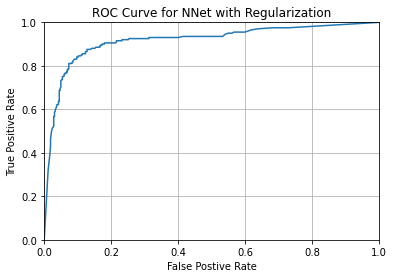

In [85]:
thresh = np.linspace(0, 1, 500)
tpr = []
fpr = []

for i in thresh:
    
    Y_p = (predictions[:, 1] > i).astype(int)
    tn, fp, fn, tp = confusion_matrix(Y_t, Y_p).ravel()
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
    
    
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NNet with Regularization')
plt.grid(True)
plt.show()

Things to add: 

* Try Feature Selection with Random Forest (with tuning and metrics in scikit-leanrn) or PCA. 
* Ex: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* and https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* Bagging (incase the random starting configurations change the minima, averaging may help)
* ROC curves and matrices, precision recall curves, and F1 scores. 